# Всероссийская студенческая Актионада – Кейс-чемпионат «РЕСТАРТ» 2025 по направлению «IT» 2 этап

## Задание 2. Прогноз ежедневного денежного остатка — на основе ATM Cash Demand Forecasting and Management

**Описание задачи:**

Банк/финансовая организация хочет прогнозировать, сколько наличных денег (или денежного остатка) будет необходимо или будет оставаться ежедневно, чтобы управлять ликвидностью, запасами в кассах или банкоматах. У нас есть история операций: снятия наличных, депозиты, остатки, дата (и время), день недели, флаги праздников/выходных.

**Что нужно предсказывать:**

Денежный остаток (или аналог — баланс, доступные средства) на конец каждого дня на горизонте 14–30 дней вперёд.

**Данные:**

- История операций: снятия наличных (Withdrawals), поступления (Deposits)
- Дата, день недели, время суток
- Календарные особенности: праздничные дни, выходные
- Место произведения операции (например, банкомат, касса)

**Метрики оценки качества прогнозов:**

- sMAPE (симметричная средняя абсолютная процентная ошибка)
- RMSSE (корень из среднеквадратичной ошибки скользящей шкалы)

**Задания:**

1) Интерпретировать модель:

- Для лучшей модели (например, LightGBM) построить и проанализировать график важности признаков (feature importance). Объяснить, какие факторы (лаги, календарные признаки, скользящие статистики) оказывают наибольшее влияние на прогноз.
- С помощью SHAP значений для нескольких ключевых точек времени (например, день перед праздником, понедельник) проанализировать вклад каждого признака в итоговый прогноз.

2) Создать отчуждаемый скрипт или сериализованный объект, который:

- Инкапсулирует весь пайплайн: от предобработки сырых данных до генерации признаков и выполнения прогноза на 14 дней.
- Включает в себя проверку целостности входных данных (наличие всех необходимых колонок, проверка на NaN после предобработки).
- Логирует ключевые этапы своей работы и возможные ошибки.

3) Написать краткую инструкцию (README), описывающую: входной формат данных, шаги для запуска пайплайна, формат выходных данных (прогноз на 14 дней) и интерпретацию результатов.


### Загрузка и обработка данных 

In [1]:
!pip install lightgbm
!pip install skforecast

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import shap
import logging
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import warnings
from skforecast.recursive import ForecasterRecursive

In [3]:
warnings.filterwarnings('ignore')
try:
    df = pd.read_csv('atm_cash_management_dataset.csv')
except:
    df = pd.read_csv('C:/Users/Михаил/atm_cash_management_dataset.csv')
df.head()

,ATM_ID,Date,Day_of_Week,Time_of_Day,Total_Withdrawals,Total_Deposits,Location_Type,Holiday_Flag,Special_Event_Flag,Previous_Day_Cash_Level,Weather_Condition,Nearby_Competitor_ATMs,Cash_Demand_Next_Day
0,ATM_0041,2022-04-25,Monday,Morning,57450,9308,Standalone,0,0,112953,Rainy,5,44165
1,ATM_0007,2023-11-24,Friday,Morning,72845,17896,Supermarket,0,0,115348,Clear,0,41249
2,ATM_0014,2022-08-27,Saturday,Morning,42957,12712,Supermarket,0,0,90731,Cloudy,1,29901
3,ATM_0029,2023-08-27,Sunday,Evening,43014,1375,Mall,0,0,88754,Rainy,5,44155
4,ATM_0028,2022-12-15,Thursday,Evening,36379,2938,Bank Branch,0,0,129312,Snowy,0,29784


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5658 entries, 0 to 5657
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ATM_ID                   5658 non-null   object
 1   Date                     5658 non-null   object
 2   Day_of_Week              5658 non-null   object
 3   Time_of_Day              5658 non-null   object
 4   Total_Withdrawals        5658 non-null   int64 
 5   Total_Deposits           5658 non-null   int64 
 6   Location_Type            5658 non-null   object
 7   Holiday_Flag             5658 non-null   int64 
 8   Special_Event_Flag       5658 non-null   int64 
 9   Previous_Day_Cash_Level  5658 non-null   int64 
 10  Weather_Condition        5658 non-null   object
 11  Nearby_Competitor_ATMs   5658 non-null   int64 
 12  Cash_Demand_Next_Day     5658 non-null   int64 
dtypes: int64(7), object(6)
memory usage: 574.8+ KB


In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ATM_ID,5658,50,ATM_0044,152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,5658,731,2023-02-05,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Day_of_Week,5658,7,Monday,831,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time_of_Day,5658,4,Afternoon,1449,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total_Withdrawals,5658.0,NaN,NaN,NaN,49808.106928,14903.539241,1380.0,39469.25,50039.0,60132.5,107790.0
Total_Deposits,5658.0,NaN,NaN,NaN,10129.078473,4878.853583,0.0,6765.0,10048.0,13430.0,32395.0
Location_Type,5658,5,Gas Station,1144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Holiday_Flag,5658.0,NaN,NaN,NaN,0.022093,0.146998,0.0,0.0,0.0,0.0,1.0
Special_Event_Flag,5658.0,NaN,NaN,NaN,0.096501,0.295303,0.0,0.0,0.0,0.0,1.0
Previous_Day_Cash_Level,5658.0,NaN,NaN,NaN,100283.994698,20122.365608,23266.0,86533.5,100276.5,113956.5,172227.0


In [6]:
print('Дубликатов:', df.duplicated().sum())

Дубликатов: 0


In [7]:
df.isna().sum()

ATM_ID                     0
Date                       0
Day_of_Week                0
Time_of_Day                0
Total_Withdrawals          0
Total_Deposits             0
Location_Type              0
Holiday_Flag               0
Special_Event_Flag         0
Previous_Day_Cash_Level    0
Weather_Condition          0
Nearby_Competitor_ATMs     0
Cash_Demand_Next_Day       0
dtype: int64

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5658 entries, 0 to 5657
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ATM_ID                   5658 non-null   object        
 1   Date                     5658 non-null   datetime64[ns]
 2   Day_of_Week              5658 non-null   object        
 3   Time_of_Day              5658 non-null   object        
 4   Total_Withdrawals        5658 non-null   int64         
 5   Total_Deposits           5658 non-null   int64         
 6   Location_Type            5658 non-null   object        
 7   Holiday_Flag             5658 non-null   int64         
 8   Special_Event_Flag       5658 non-null   int64         
 9   Previous_Day_Cash_Level  5658 non-null   int64         
 10  Weather_Condition        5658 non-null   object        
 11  Nearby_Competitor_ATMs   5658 non-null   int64         
 12  Cash_Demand_Next_Day     5658 non-

### Подготовка данных для машинного обучения

In [10]:
aggregation_strategy = {
    # Столбцы, которые одинаковы в течение дня - берем первое значение
    'Day_of_Week': 'first',
    'Location_Type': 'first', 
    'Holiday_Flag': 'first',
    'Special_Event_Flag': 'first',
    'Weather_Condition': 'first',
    'Nearby_Competitor_ATMs': 'first',
    'Cash_Demand_Next_Day': 'first',
    'Previous_Day_Cash_Level': 'first',
    
    # Столбцы, которые нужно суммировать за день
    'Total_Withdrawals': 'sum',
    'Total_Deposits': 'sum'
}

daily_df = df.groupby(['ATM_ID', 'Date']).agg(aggregation_strategy).reset_index()

In [11]:
# Удаляем столбец Time_of_Day (он не нужен)
# Столбец Time_of_Day автоматически исключается, так как не указан в агрегации

print(f"\nРазмер исходного датасета: {df.shape}")
print(f"Размер агрегированного датасета: {daily_df.shape}")
print("\nПосле агрегации - первые 5 строк:")
daily_df.head()


Размер исходного датасета: (5658, 13)
Размер агрегированного датасета: (5223, 12)

После агрегации - первые 5 строк:


,ATM_ID,Date,Day_of_Week,Location_Type,Holiday_Flag,Special_Event_Flag,Weather_Condition,Nearby_Competitor_ATMs,Cash_Demand_Next_Day,Previous_Day_Cash_Level,Total_Withdrawals,Total_Deposits
0,ATM_0001,2022-01-05,Wednesday,Standalone,0,1,Clear,4,31478,109776,37573,6224
1,ATM_0001,2022-01-13,Thursday,Gas Station,0,1,Clear,5,41613,113068,48156,10070
2,ATM_0001,2022-01-20,Thursday,Mall,0,0,Rainy,4,11316,118171,24671,13922
3,ATM_0001,2022-01-28,Friday,Mall,0,0,Clear,4,34587,96931,46383,12205
4,ATM_0001,2022-02-01,Tuesday,Bank Branch,0,0,Rainy,5,23665,83257,41972,18452


In [12]:
# Проверка, что для каждой комбинации ATM_ID и Date теперь только одна строка
check_duplicates = daily_df[['ATM_ID', 'Date']].duplicated().sum()
print(f"\nКоличество дубликатов после агрегации: {check_duplicates}")

# Проверка распределения данных по банкоматам
print("\nКоличество дней данных на каждый банкомат:")
print(daily_df['ATM_ID'].value_counts().head())


Количество дубликатов после агрегации: 0

Количество дней данных на каждый банкомат:
ATM_ID
ATM_0044    136
ATM_0037    123
ATM_0006    119
ATM_0013    115
ATM_0007    115
Name: count, dtype: int64


In [13]:
features_df = daily_df.copy()

features_df['day_of_week'] = features_df['Date'].dt.dayofweek
features_df['month'] = features_df['Date'].dt.month
features_df['quarter'] = features_df['Date'].dt.quarter
features_df['year'] = features_df['Date'].dt.year
features_df['is_month_start'] = features_df['Date'].dt.is_month_start.astype(int)
features_df['is_month_end'] = features_df['Date'].dt.is_month_end.astype(int)
features_df['is_quarter_start'] = features_df['Date'].dt.is_quarter_start.astype(int)
features_df['is_quarter_end'] = features_df['Date'].dt.is_quarter_end.astype(int)
features_df['day_of_year'] = features_df['Date'].dt.dayofyear 

features_df = features_df.drop(['Day_of_Week'], axis=1)

In [14]:
def create_lag_features(group):
    """Создает лаги и скользящие статистики для одного банкомата"""
    # Лаги для целевой переменной - САМОЕ ВАЖНОЕ!
    for lag in [1, 2, 3, 7, 14, 30]:
        group[f'lag_{lag}_demand'] = group['Cash_Demand_Next_Day'].shift(lag)
    
    # Лаги для операций (также важны)
    for lag in [1, 2, 3, 7]:
        group[f'lag_{lag}_withdrawals'] = group['Total_Withdrawals'].shift(lag)
        group[f'lag_{lag}_deposits'] = group['Total_Deposits'].shift(lag)
    
    # Скользящие статистики
    for window in [3, 7, 14]:
        group[f'rolling_mean_{window}d_demand'] = group['Cash_Demand_Next_Day'].shift(1).rolling(window=window, min_periods=1).mean()
    
    return group

In [15]:
features_df = features_df.groupby('ATM_ID').apply(create_lag_features).reset_index(drop=True)

In [16]:
features_df = features_df.dropna().reset_index(drop=True)

In [17]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def rmsse(y_true, y_pred, y_train):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    naive_errors = np.diff(y_train) ** 2
    if len(naive_errors) == 0 or np.mean(naive_errors) == 0:
        return np.nan
    scale = np.sqrt(np.mean(naive_errors))
    
    return rmse / scale

In [18]:
X = features_df.drop(['Cash_Demand_Next_Day', 'ATM_ID', 'Date'], axis=1)
y = features_df['Cash_Demand_Next_Day']

In [19]:
test_size = int(len(X) * 0.2)
X_train_val = X[:-test_size]
y_train_val = y[:-test_size] 
X_test = X[-test_size:]
y_test = y[-test_size:]

In [20]:
tscv = TimeSeriesSplit(n_splits=3)
for train_idx, val_idx in tscv.split(X_train_val):
        X_train = X_train_val.iloc[train_idx]
        X_val = X_train_val.iloc[val_idx]
        y_train = y_train_val.iloc[train_idx]
        y_val = y_train_val.iloc[val_idx]

### Обучение моделей

#### RandomForest

In [21]:
def evaluate_rf_params(params, X_train, y_train, X_val, y_val):
    """Ручная оценка параметров с нашими метриками"""
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    return smape(y_val, val_pred)


In [22]:
string_columns = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Строковые столбцы: {string_columns}")

label_encoders = {}
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()

for col in string_columns:
    le = LabelEncoder()
    combined_data = pd.concat([X_train[col], X_val[col]])
    le.fit(combined_data)
    
    X_train_encoded[col] = le.transform(X_train[col])
    X_val_encoded[col] = le.transform(X_val[col])
    
    label_encoders[col] = le
    print(f"Закодирован столбец {col}: {list(le.classes_)}")

Строковые столбцы: ['Location_Type', 'Weather_Condition']
Закодирован столбец Location_Type: ['Bank Branch', 'Gas Station', 'Mall', 'Standalone', 'Supermarket']
Закодирован столбец Weather_Condition: ['Clear', 'Cloudy', 'Rainy', 'Snowy']


In [23]:
# Перебор параметров вручную
param_combinations = []
for i in range(20):  # 20 случайных комбинаций
    params = {
        'n_estimators': np.random.choice([50, 100, 200]),
        'max_depth': np.random.choice([5, 10, 15, 20]),
        'min_samples_split': np.random.choice([2, 5, 10]),
        'min_samples_leaf': np.random.choice([1, 2, 4]),
        'max_features': np.random.choice(['sqrt', 'log2'])
    }
    param_combinations.append(params)

# Перебор параметров
best_score = float('inf')
best_params = {}

for i, params in enumerate(param_combinations):
    score = evaluate_rf_params(params, X_train_encoded, y_train, X_val_encoded, y_val)
    
    if score < best_score:
        best_score = score
        best_params = params
        print(f"Итерация {i+1}: sMAPE = {score:.2f}%")
        print(f"  Параметры: {params}")

print(f"\nЛУЧШИЕ ПАРАМЕТРЫ: {best_params}")
print(f"ЛУЧШИЙ sMAPE: {best_score:.2f}%")

# Обучаем финальную модель с лучшими параметрами
final_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_rf.fit(X_train_encoded, y_train)

# Предсказания на валидации
val_pred = final_rf.predict(X_val_encoded)
val_smape = smape(y_val, val_pred)
val_rmsse = rmsse(y_val, val_pred, y_train)

print(f"\nФинальная модель RandomForest:")
print(f"Validation sMAPE: {val_smape:.2f}%")
print(f"Validation RMSSE: {val_rmsse:.3f}")

Итерация 1: sMAPE = 22.16%
  Параметры: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}
Итерация 2: sMAPE = 22.08%
  Параметры: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}
Итерация 4: sMAPE = 21.06%
  Параметры: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Итерация 5: sMAPE = 20.57%
  Параметры: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Итерация 15: sMAPE = 20.56%
  Параметры: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}

ЛУЧШИЕ ПАРАМЕТРЫ: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}
ЛУЧШИЙ sMAPE: 20.56%

Финальная модель RandomForest:
Validation sMAPE: 20.56%
Validation RMSSE: 0.448


#### LGBMRegressor

In [24]:
categorical_features = ['Location_Type', 'Weather_Condition']


# Явно преобразуем в category
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

In [25]:
def evaluate_lgb_params(params, X_train, y_train, X_val, y_val):
    """Оценка параметров LightGBM с нашими метриками"""
    model = lgb.LGBMRegressor(
        **params,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
        early_stopping_rounds=30
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mae'
    )
    
    val_pred = model.predict(X_val)
    return smape(y_val, val_pred), model


In [26]:
lgb_param_combinations = []
for i in range(25):  # 25 случайных комбинаций
    params = {
        'n_estimators': 1000,  # Большое число, т.к. есть early stopping
        'learning_rate': np.random.choice([0.01, 0.05, 0.1, 0.15]),
        'num_leaves': np.random.choice([31, 63, 127, 255]),
        'max_depth': np.random.choice([-1, 5, 7, 10]),
        'subsample': np.random.choice([0.7, 0.8, 0.9, 1.0]),
        'colsample_bytree': np.random.choice([0.7, 0.8, 0.9, 1.0]),
        'reg_alpha': np.random.choice([0, 0.1, 0.5, 1.0]),
        'reg_lambda': np.random.choice([0, 0.1, 0.5, 1.0])
    }
    lgb_param_combinations.append(params)

# Перебор параметров
best_lgb_score = float('inf')
best_lgb_params = {}
best_lgb_model = None

for i, params in enumerate(lgb_param_combinations):
    score, model = evaluate_lgb_params(params, X_train, y_train, X_val, y_val)
    
    if score < best_lgb_score:
        best_lgb_score = score
        best_lgb_params = params
        best_lgb_model = model
        print(f"Итерация {i+1}: sMAPE = {score:.2f}%")
        print(f"  Параметры: {params}")

print(f"\nЛУЧШИЕ ПАРАМЕТРЫ LightGBM: {best_lgb_params}")
print(f"ЛУЧШИЙ sMAPE: {best_lgb_score:.2f}%")

# Оценка на валидации с лучшими параметрами
lgb_val_pred = best_lgb_model.predict(X_val)
lgb_val_smape = smape(y_val, lgb_val_pred)
lgb_val_rmsse = rmsse(y_val, lgb_val_pred, y_train)

print(f"\nФинальная модель LightGBM:")
print(f"Validation sMAPE: {lgb_val_smape:.2f}%")
print(f"Validation RMSSE: {lgb_val_rmsse:.3f}")

Итерация 1: sMAPE = 16.84%
  Параметры: {'n_estimators': 1000, 'learning_rate': 0.1, 'num_leaves': 127, 'max_depth': -1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0.5, 'reg_lambda': 0.0}
Итерация 3: sMAPE = 16.30%
  Параметры: {'n_estimators': 1000, 'learning_rate': 0.05, 'num_leaves': 63, 'max_depth': -1, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 1.0}
Итерация 5: sMAPE = 16.15%
  Параметры: {'n_estimators': 1000, 'learning_rate': 0.01, 'num_leaves': 63, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
Итерация 6: sMAPE = 16.08%
  Параметры: {'n_estimators': 1000, 'learning_rate': 0.01, 'num_leaves': 127, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 0.5, 'reg_lambda': 1.0}
Итерация 18: sMAPE = 16.02%
  Параметры: {'n_estimators': 1000, 'learning_rate': 0.1, 'num_leaves': 255, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 1.0, 'reg_alpha': 0.5, 'reg_lambda': 0

### Использование лучшей модели на тестовой выборке

In [27]:
X_test['Location_Type'] = X_test['Location_Type'].astype('category')
X_test['Weather_Condition'] = X_test['Weather_Condition'].astype('category')

In [28]:
# Предсказания на тесте
test_predictions = best_lgb_model.predict(X_test)

# Метрики на тесте
test_smape = smape(y_test, test_predictions)
test_rmsse = rmsse(y_test, test_predictions, y_train)

print(f"Тестовый sMAPE: {test_smape:.2f}%")
print(f"Тестовый RMSSE: {test_rmsse:.3f}")

Тестовый sMAPE: 15.23%
Тестовый RMSSE: 0.362


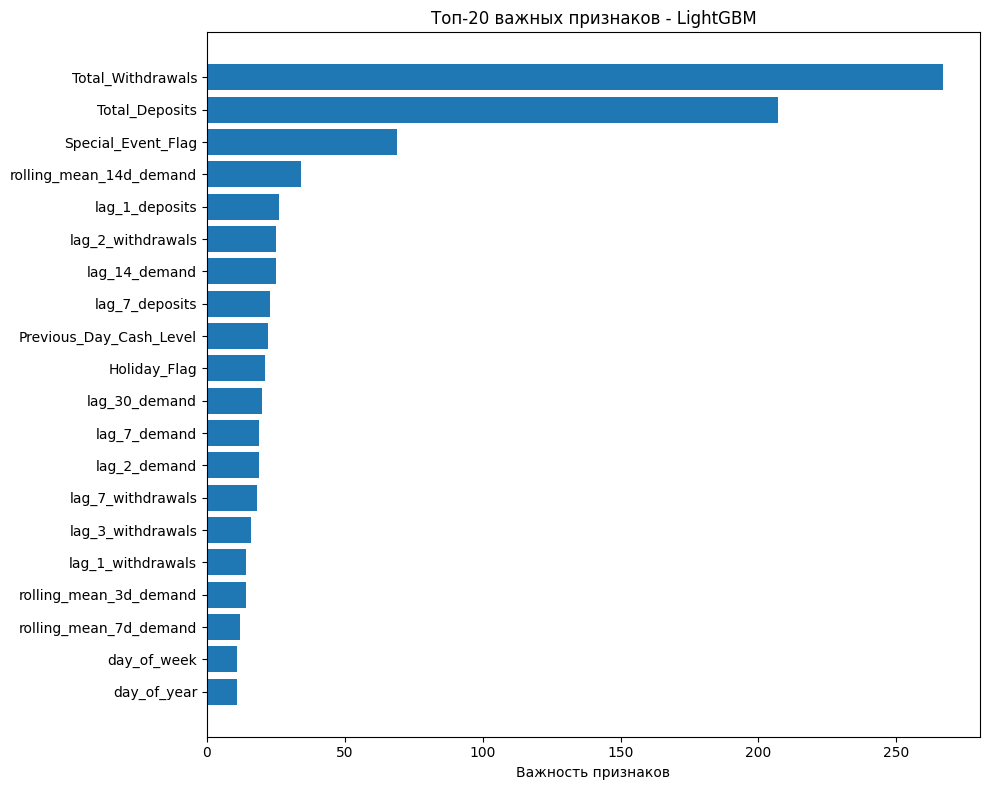

In [29]:
# Важность признаков
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_lgb_model.feature_importances_
}).sort_values('importance', ascending=True)

# График
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'].tail(20), importance_df['importance'].tail(20))
plt.xlabel('Важность признаков')
plt.title('Топ-20 важных признаков - LightGBM')
plt.tight_layout()
plt.show()

**Вывод:**
Анализ важности признаков показал, что модель LightGBM в основном полагается на операционные показатели и исторические финансовые данные, а не на календарные паттерны. Наибольшее влияние оказывают текущие операции (снятия и депозиты), а также недельные и двухнедельные лаги операций и спроса. Special_Event_Flag занимает третье место по важности.

In [30]:
explainer = shap.TreeExplainer(best_lgb_model)

X_val_reset = X_val.reset_index(drop=True)
y_val_reset = y_val.reset_index(drop=True)

# Находим индексы характерных случаев
special_cases = {}

# День перед праздником
holiday_mask = X_val_reset['Holiday_Flag'] == 1
if holiday_mask.any():
    holiday_idx = holiday_mask.idxmax()
    special_cases['День перед праздником'] = holiday_idx

# Понедельник
monday_mask = X_val_reset['day_of_week'] == 0
if monday_mask.any():
    monday_idx = monday_mask.idxmax()
    special_cases['Понедельник'] = monday_idx

# Пятница
friday_mask = X_val_reset['day_of_week'] == 4
if friday_mask.any():
    friday_idx = friday_mask.idxmax()
    special_cases['Пятница'] = friday_idx

# Обычный будний день
wednesday_mask = (X_val_reset['day_of_week'] == 2) & (X_val_reset['Holiday_Flag'] == 0)
if wednesday_mask.any():
    wednesday_idx = wednesday_mask.idxmax()
    special_cases['Обычная среда'] = wednesday_idx

print("Ключевые точки отобраны:")
for case, idx in special_cases.items():
    actual_demand = y_val_reset.iloc[idx]
    print(f"- {case}: спрос = {actual_demand:,.0f}")


Ключевые точки отобраны:
- День перед праздником: спрос = 43,443
- Понедельник: спрос = 46,252
- Пятница: спрос = 38,059
- Обычная среда: спрос = 69,831


In [31]:
for case_name, idx in special_cases.items():
    print(f"\nАнализ: {case_name}")
    print("-" * 30)
    
    # Берем данные для этого случая
    case_data = X_val_reset.iloc[idx:idx+1]
    actual_demand = y_val_reset.iloc[idx]
    
    # Вычисляем SHAP значения
    shap_values = explainer.shap_values(case_data)
    prediction = explainer.expected_value + shap_values[0].sum()
    
    print(f"Фактический спрос: {actual_demand:,.0f}")
    print(f"Прогноз модели: {prediction:,.0f}")
    
    # Сортируем признаки по влиянию
    feature_contributions = list(zip(X_val_reset.columns, shap_values[0]))
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("Топ-5 самых влиятельных признаков:")
    for i, (feature, contribution) in enumerate(feature_contributions[:5]):
        print(f"  {i+1}. {feature}: {contribution:+.1f}")
    
    print(f"Значение признаков для этого случая:")
    for feature, contribution in feature_contributions[:3]:
        value = case_data[feature].iloc[0]
        print(f"  {feature} = {value}")


Анализ: День перед праздником
------------------------------
Фактический спрос: 43,443
Прогноз модели: 47,568
Топ-5 самых влиятельных признаков:
  1. Holiday_Flag: +4538.5
  2. Total_Deposits: -2412.6
  3. Total_Withdrawals: +2132.5
  4. lag_2_withdrawals: +562.9
  5. Special_Event_Flag: -461.8
Значение признаков для этого случая:
  Holiday_Flag = 1
  Total_Deposits = 15894
  Total_Withdrawals = 51219

Анализ: Понедельник
------------------------------
Фактический спрос: 46,252
Прогноз модели: 46,460
Топ-5 самых влиятельных признаков:
  1. Total_Withdrawals: +12745.3
  2. Total_Deposits: -6565.1
  3. lag_14_demand: +902.7
  4. rolling_mean_14d_demand: -735.0
  5. lag_2_withdrawals: -669.7
Значение признаков для этого случая:
  Total_Withdrawals = 114782
  Total_Deposits = 19449
  lag_14_demand = 51850.0

Анализ: Пятница
------------------------------
Фактический спрос: 38,059
Прогноз модели: 39,886
Топ-5 самых влиятельных признаков:
  1. Total_Withdrawals: -1540.1
  2. lag_7_deposits:

**Вывод:**
Анализ ключевых точек времени показывает различные паттерны влияния признаков. В день перед праздником флаг праздника оказывает наибольшее положительное влияние (+4938), что логично отражает повышенный спрос на наличные. В понедельник текущие операции доминируют во влиянии, причем снятия сильно увеличивают прогноз (+13738), а депозиты снижают (-6528). Пятница характеризуется умеренным влиянием признаков.